# Озёра данных в Яндекс облаке
В этом воркшопе мы посмотрим на несколько примеров работы с датаплатформой YandexCloud\
Основная идея показать как можно построить гетерогенную обработку, хранение и аналилитику данных в облаке.\
В последнее время становятся популярными решения, основанные на концепции DataLake\

## Что такое Data Lake (Озеро данных)?
Озеро данных — это централизованный репозиторий, который позволяет хранить все ваши структурированные и неструктурированные данные в любом масштабе. Вы можете хранить свои данные как есть, без предварительной структуризации данных и запуска различных типов аналитики — от информационных панелей и визуализаций до обработки больших данных, аналитики в реальном времени и машинного обучения для принятия более эффективных решений.

## Озера данных по сравнению с хранилищами данных — два разных подхода
В зависимости от требований типичной организации потребуется как хранилище данных, так и озеро данных, поскольку они служат различным потребностям и вариантам использования.

Хранилище данных — это база данных, оптимизированная для анализа реляционных данных, поступающих из транзакционных систем и ряда бизнес-приложений. Структура данных и схема определяются заранее для оптимизации быстрых запросов SQL, результаты которых обычно используются для оперативной отчетности и анализа. Данные очищаются, обогащаются и преобразуются, чтобы они могли выступать в качестве «единого источника правды», которому пользователи могут доверять.

Озеро данных отличается тем, что в нем хранятся реляционные данные из линейки бизнес-приложений и нереляционные данные из мобильных приложений, устройств IoT и социальных сетей. Структура данных или схема не определяется при захвате данных. Это означает, что вы можете хранить все свои данные без тщательного проектирования или необходимости знать, на какие вопросы вам могут понадобиться ответы в будущем. Различные типы аналитики ваших данных, такие как SQL-запросы, аналитика больших данных, полнотекстовый поиск, аналитика в реальном времени и машинное обучение, могут использоваться для раскрытия информации.

Data Lake (озеро данных) может использовать единый репозиторий.\
В качестве хранилища данных на текущий момент самым популярным, удобным, функциональным и экономически выгодным способом, является смользование Объекного хранилища в S3 совместимым протоколом доступа.

## Архитектура сегодняшнего воркшопа
Данные с внешнисх систем поступают каки-либо образом на объектное хранлище, например в виде CSV файликов.
Далее, при помощи Spark обработчиков под управлением кода запускаемого из визуального инструмента DataSphere эти данные перекладываются в унифицированное хранилище с подержкой обновления, 

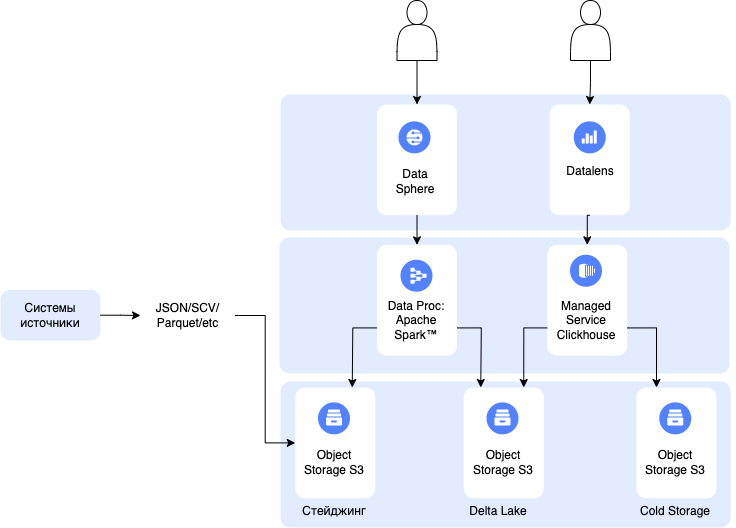

In [120]:
%create_livy_session \
--cluster ephemeral-cluster \
--id ses1 \
--conf spark.jars.packages=io.delta:delta-core_2.12:0.8.0 \
--conf spark.sql.extensions=io.delta.sql.DeltaSparkSessionExtension \
--conf spark.sql.catalog.spark_catalog=org.apache.spark.sql.delta.catalog.DeltaCatalog \
--conf spark.sql.hive.metastore.sharedPrefixes=com.amazonaws,ru.yandex.cloud \
--conf spark.sql.warehouse.dir=s3a://keshaaa/wh

Starting session ses1


In [121]:
#!spark --cluster ephemeral-cluster --session ses1
S3_BUCKET_NAME="keshaaa"
inputDF = spark.createDataFrame(
    [
        ("100", "2015-01-01", "2015-01-01T13:51:39.340396Z"),
        ("101", "2015-01-01", "2015-01-01T12:14:58.597216Z"),
        ("102", "2015-01-01", "2015-01-01T13:51:40.417052Z"),
        ("103", "2015-01-01", "2015-01-01T13:51:40.519832Z"),
        ("104", "2015-01-02", "2015-01-01T12:15:00.512679Z"),
        ("105", "2015-01-02", "2015-01-01T13:51:42.248818Z"),
    ],
    ["id", "creation_date", "last_update_time"],
)

# Write a DataFrame as a Delta dataset
inputDF.write.format("delta").mode("overwrite").option(
    "overwriteSchema", "true"
).partitionBy("creation_date").save(f"s3a://{S3_BUCKET_NAME}/tmp/delta/")

Waiting for an Apache Livy session to start...
Apache Livy session has started.



In [122]:
%%sh

ls -lR /home/jupyter/datasphere/s3/s3fs/tmp/delta | tee /tmp/delta_op_001

/home/jupyter/datasphere/s3/s3fs/tmp/delta:
total 2
drwxrwxrwx 1 root root 0 Jan  1  1970 _delta_log
drwxrwxrwx 1 root root 0 Jan  1  1970 creation_date=2015-01-01
drwxrwxrwx 1 root root 0 Jan  1  1970 creation_date=2015-01-02
drwxrwxrwx 1 root root 0 Jan  1  1970 creation_date=2022-01-11

/home/jupyter/datasphere/s3/s3fs/tmp/delta/_delta_log:
total 3
-rwxrwxrwx 1 root root 1451 Jul  3 16:54 00000000000000000000.json
-rwxrwxrwx 1 root root 1461 Jul  3 16:55 00000000000000000001.json

/home/jupyter/datasphere/s3/s3fs/tmp/delta/creation_date=2015-01-01:
total 4
-rwxrwxrwx 1 root root 793 Jul  3 16:54 part-00000-5e6ff72f-54e3-4f5f-8c18-ec203ff86455.c000.snappy.parquet
-rwxrwxrwx 1 root root 875 Jul  3 16:54 part-00001-ae426758-da19-46cf-9e9b-b4b1fdd2653d.c000.snappy.parquet
-rwxrwxrwx 1 root root 875 Jul  3 16:54 part-00011-475a45c6-2216-4362-a031-70e9518a46ec.c000.snappy.parquet
-rwxrwxrwx 1 root root 875 Jul  3 16:54 part-00088-ed714df7-40f6-4198-876c-cd424c50cdb0.c000.snappy.parquet

/

In [113]:
#!spark --cluster ephemeral-cluster --session ses1
from pyspark.sql.functions import lit

# Create a new DataFrame from the first row of inputDF with a different creation_date value
updateDF = inputDF.where("id = 100").withColumn("creation_date", lit("2022-01-11"))

from delta.tables import *
from pyspark.sql.functions import *

deltaTable = DeltaTable.forPath(spark, f"s3a://{S3_BUCKET_NAME}/tmp/delta/")

deltaTable.alias("oldData") \
  .merge(
    updateDF.alias("newData"),
    "oldData.id = newData.id") \
  .whenMatchedUpdate(set = { "creation_date": col("newData.creation_date") }) \
  .execute()

deltaTable.toDF().show()

Traceback (most recent call last):
NameError: name 'inputDF' is not defined



Exception: 

In [90]:
#!spark --cluster ephemeral-cluster --session ses1
inputDF.show()

+---+-------------+--------------------+
| id|creation_date|    last_update_time|
+---+-------------+--------------------+
|100|   2015-01-01|2015-01-01T13:51:...|
|101|   2015-01-01|2015-01-01T12:14:...|
|102|   2015-01-01|2015-01-01T13:51:...|
|103|   2015-01-01|2015-01-01T13:51:...|
|104|   2015-01-02|2015-01-01T12:15:...|
|105|   2015-01-02|2015-01-01T13:51:...|
+---+-------------+--------------------+


In [112]:
#!spark --cluster ephemeral-cluster --session ses1
deltaTable.history().show()

Waiting for an Apache Livy session to start...
Apache Livy session has started.


Traceback (most recent call last):
NameError: name 'deltaTable' is not defined



Exception: 

In [163]:
#!spark --cluster ephemeral-cluster --session ses1
pd.set_option('display.max_colwidth', None)
history = spark.sql(f"DESCRIBE HISTORY delta.`s3a://{S3_BUCKET_NAME}/tmp/delta/`")
print("Список версий в табличном формате")
history.select("version", "timestamp", "operation", "operationParameters", "operationMetrics").show(truncate=42)
print("Список версий в вертикальном формате")
history.show(truncate=False,vertical=True)

latest_version = history.selectExpr("max(version)").collect()[0][0]
print(f"Самая свежая версия: {latest_version}")

Список версий в табличном формате
+-------+-------------------+---------+------------------------------------------+------------------------------------------+
|version|          timestamp|operation|                       operationParameters|                          operationMetrics|
+-------+-------------------+---------+------------------------------------------+------------------------------------------+
|      0|2023-07-07 13:58:53|    WRITE|[mode -> Overwrite, partitionBy -> ["cr...|[numFiles -> 3, numOutputBytes -> 2434,...|
+-------+-------------------+---------+------------------------------------------+------------------------------------------+

-RECORD 0--------------------------------------------------------------------------
 version             | 0                                                           
 timestamp           | 2023-07-07 13:58:53                                         
 userId              | null                                                        

In [108]:
#!spark --cluster ephemeral-cluster --session ses1
df2 = (
    spark.read.format("delta")
    .option("versionAsOf", 0)
    .load(f"s3a://{S3_BUCKET_NAME}/tmp/delta/")
)
df2.sort("id").show()
df2 = (
    spark.read.format("delta")
    .option("versionAsOf", 1)
    .load(f"s3a://{S3_BUCKET_NAME}/tmp/delta/")
)
df2.sort("id").show()

+---+-------------+--------------------+
| id|creation_date|    last_update_time|
+---+-------------+--------------------+
|100|   2015-01-01|2015-01-01T13:51:...|
|101|   2015-01-01|2015-01-01T12:14:...|
|102|   2015-01-01|2015-01-01T13:51:...|
|103|   2015-01-01|2015-01-01T13:51:...|
|104|   2015-01-02|2015-01-01T12:15:...|
|105|   2015-01-02|2015-01-01T13:51:...|
+---+-------------+--------------------+

+---+-------------+--------------------+
| id|creation_date|    last_update_time|
+---+-------------+--------------------+
|100|   2022-01-11|2015-01-01T13:51:...|
|101|   2015-01-01|2015-01-01T12:14:...|
|102|   2015-01-01|2015-01-01T13:51:...|
|103|   2015-01-01|2015-01-01T13:51:...|
|104|   2015-01-02|2015-01-01T12:15:...|
|105|   2015-01-02|2015-01-01T13:51:...|
+---+-------------+--------------------+


In [109]:
#!spark --cluster ephemeral-cluster --session ses1
spark.sql(f"VACUUM delta.`s3a://{S3_BUCKET_NAME}/tmp/delta/`")

DataFrame[path: string]


In [101]:
%%bash

ls -lR /home/jupyter/datasphere/s3/s3fs/tmp/delta | tee /tmp/delta_op_002

/home/jupyter/datasphere/s3/s3fs/tmp/delta:
total 2
drwxrwxrwx 1 root root 0 Jan  1  1970 _delta_log
drwxrwxrwx 1 root root 0 Jan  1  1970 creation_date=2015-01-01
drwxrwxrwx 1 root root 0 Jan  1  1970 creation_date=2015-01-02
drwxrwxrwx 1 root root 0 Jan  1  1970 creation_date=2022-01-11

/home/jupyter/datasphere/s3/s3fs/tmp/delta/_delta_log:
total 3
-rwxrwxrwx 1 root root 1451 Jul  3 16:54 00000000000000000000.json
-rwxrwxrwx 1 root root 1461 Jul  3 16:55 00000000000000000001.json

/home/jupyter/datasphere/s3/s3fs/tmp/delta/creation_date=2015-01-01:
total 4
-rwxrwxrwx 1 root root 793 Jul  3 16:54 part-00000-5e6ff72f-54e3-4f5f-8c18-ec203ff86455.c000.snappy.parquet
-rwxrwxrwx 1 root root 875 Jul  3 16:54 part-00001-ae426758-da19-46cf-9e9b-b4b1fdd2653d.c000.snappy.parquet
-rwxrwxrwx 1 root root 875 Jul  3 16:54 part-00011-475a45c6-2216-4362-a031-70e9518a46ec.c000.snappy.parquet
-rwxrwxrwx 1 root root 875 Jul  3 16:54 part-00088-ed714df7-40f6-4198-876c-cd424c50cdb0.c000.snappy.parquet

/

In [119]:
%delete_livy_session \
--cluster ephemeral-cluster \
--id ses1

In [167]:
#!spark --cluster ephemeral-cluster --session ses1
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
printmd("**bold and blue**", color="blue")

Traceback (most recent call last):
  File "<stdin>", line 4, in printmd
NameError: name 'display' is not defined



Exception: 

In [ ]:
help(display)

In [175]:
%%sh
pip3 --no-cache-dir install --upgrade awscli

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [178]:
%%sh
ls /usr/local/bin

__pycache__
asadmin
bundle_image
cfadmin
cfn-lint
chardetect
cmark
convert-caffe2-to-onnx
convert-onnx-to-caffe2
cq
cwutil
cygdb
cython
cythonize
distro
dvc
dynamodb_dump
dynamodb_load
easy_install
easy_install-3.8
elbadmin
estimator_ckpt_converter
f2py
f2py3
f2py3.8
fairseq-eval-lm
fairseq-generate
fairseq-interactive
fairseq-preprocess
fairseq-score
fairseq-train
fairseq-validate
fetch_file
flatten_json
futurize
get_objgraph
glacier
google-oauthlib-tool
huggingface-cli
import_pb_to_tensorboard
install_fluidsynth_with_soundfonts_osx.sh
instance_events
iptest
iptest3
ipython
ipython3
jp.py
jsondiff
jsonpatch
jsonpath_ng
jsonpointer
jsonschema
jupyter
jupyter-bundlerextension
jupyter-dejavu
jupyter-execute
jupyter-kernel
jupyter-kernelspec
jupyter-migrate
jupyter-nbconvert
jupyter-nbextension
jupyter-notebook
jupyter-run
jupyter-serverextension
jupyter-troubleshoot
jupyter-trust
kaggle
kill_instance
launch_instance
list_instances
lss3
markdown_py
midi2audio
midiplay
moto_server
mturk
no